# **UAS ANALISIS RUNTUN WAKTU**

# **PRADYTHA GALUH PUTRANTI 2304220013**

In [13]:
from google.colab import files
uploaded = files.upload()


Saving data_kualitas_udara_500hari.csv to data_kualitas_udara_500hari (1).csv


In [14]:
import pandas as pd

# Baca file yang sudah diupload (nama harus sesuai)
df = pd.read_csv("data_kualitas_udara_500hari.csv", parse_dates=["Tanggal"])
df.set_index("Tanggal", inplace=True)
df.head()


,PM2.5
Tanggal,
2023-07-17,52.48
2023-07-18,50.66
2023-07-19,55.93
2023-07-20,61.60
2023-07-21,54.06


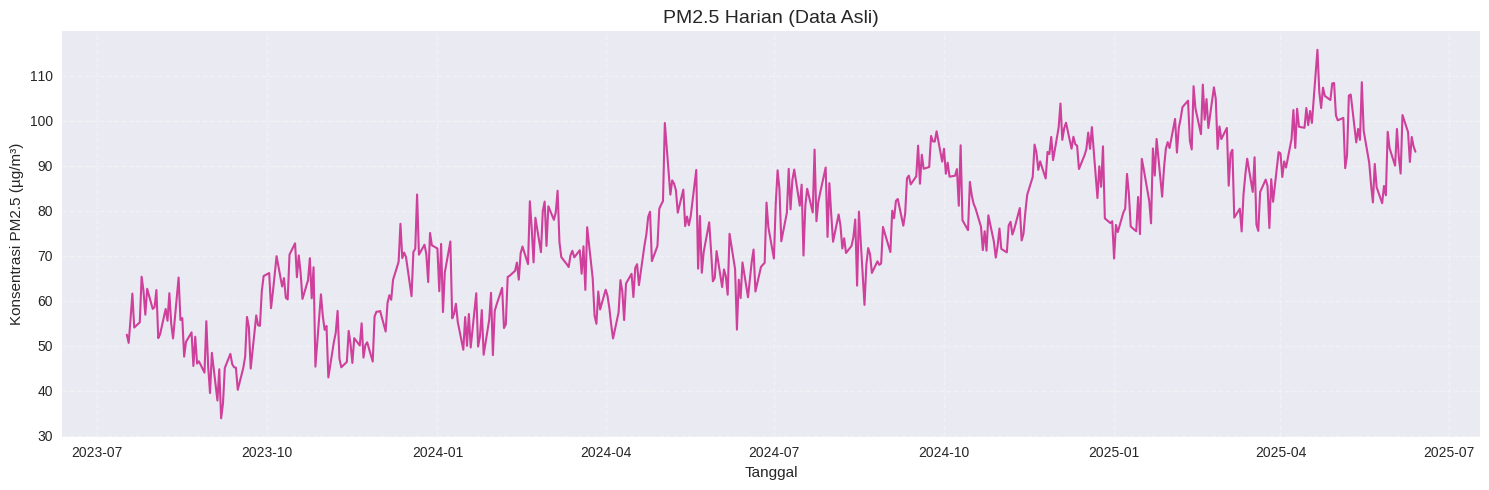

In [23]:
# Plot data asli
plt.figure(figsize=(15,5))
plt.plot(df['PM2.5'], color='mediumvioletred', linewidth=1.5, alpha=0.8)
plt.title("PM2.5 Harian (Data Asli)", fontsize=14)
plt.xlabel("Tanggal")
plt.ylabel("Konsentrasi PM2.5 (µg/m³)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

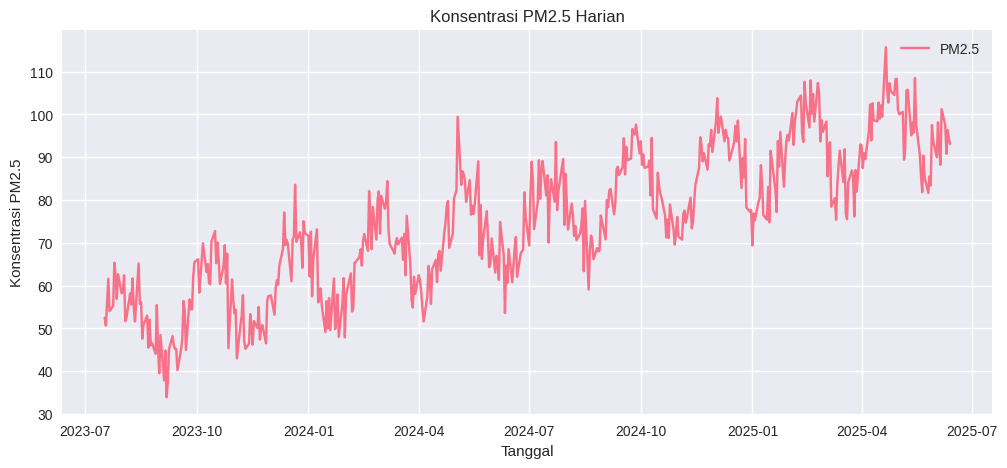

In [15]:
# Visualisasi time series PM2.5
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['PM2.5'], label='PM2.5')
plt.title("Konsentrasi PM2.5 Harian")
plt.xlabel("Tanggal")
plt.ylabel("Konsentrasi PM2.5")
plt.grid(True)
plt.legend()
plt.show()

# **PLOT ACF DAN PACF**

<Figure size 1200x500 with 0 Axes>

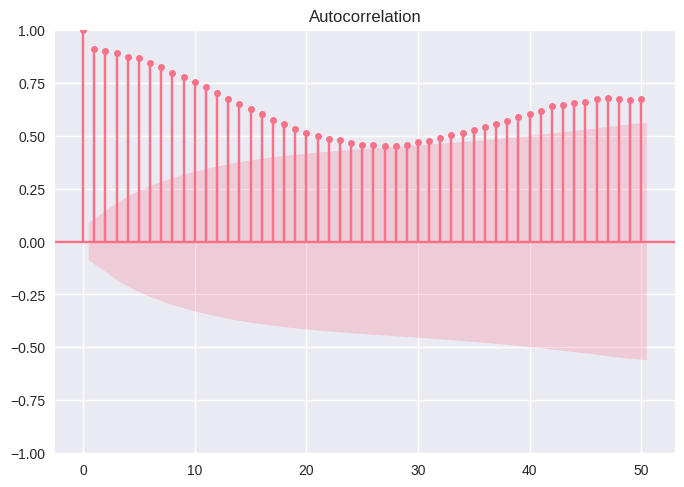

<Figure size 1200x500 with 0 Axes>

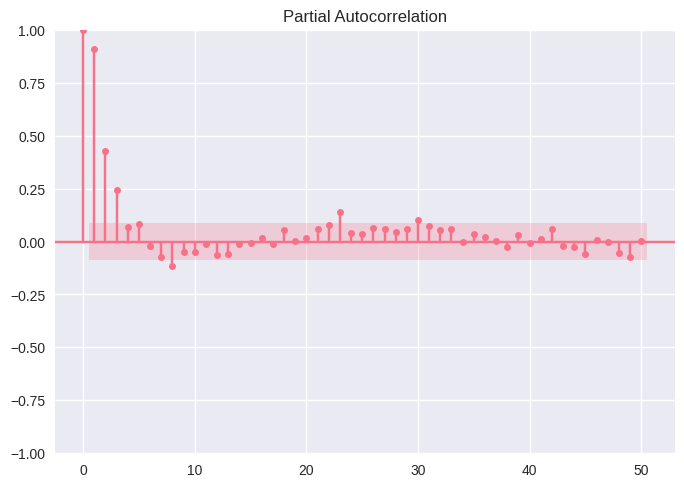

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF dan PACF
plt.figure(figsize=(12,5))
plot_acf(df['PM2.5'], lags=50)
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(df['PM2.5'], lags=50, method='ywm')
plt.show()


# **Uji Stasioneritas (ADF Test)**

In [17]:
from statsmodels.tsa.stattools import adfuller

# ADF Test
adf_result = adfuller(df['PM2.5'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: -2.4418637696396983
p-value: 0.13026749433192408


Karena p-value = 0.130 > 0.05, kita tidak bisa menolak H0.

Maka, data asli PM2.5 tidak stasioner → artinya mengandung tren atau varians tidak konstan.

# **Differencing**

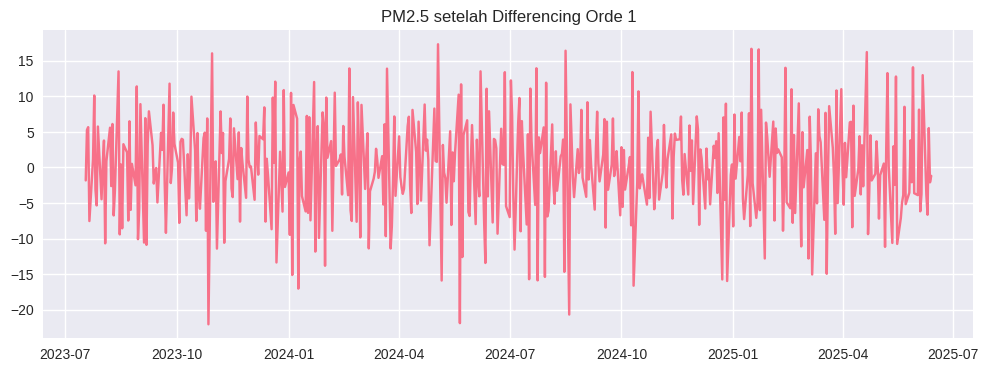

In [18]:
# Differencing orde 1 jika tidak stasioner
df_diff = df['PM2.5'].diff().dropna()

plt.figure(figsize=(12, 4))
plt.plot(df_diff)
plt.title("PM2.5 setelah Differencing Orde 1")
plt.grid(True)
plt.show()

Grafik menunjukkan bahwa setelah dilakukan differencing orde 1, data PM2.5 menjadi lebih stasioner, dengan fluktuasi acak dan tidak menunjukkan pola tren jangka panjang.
Ini menunjukkan bahwa d = 1 (differencing satu kali) sudah cukup untuk mengatasi ketidakstasioneran data asli, dan layak digunakan untuk pemodelan ARIMA atau SARIMA.

# **Pemodelan SARIMA**

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit model SARIMA (contoh: SARIMA(1,1,1)(1,0,1,7))
model = SARIMAX(df['PM2.5'],
                order=(1,1,1),
                seasonal_order=(1,0,1,7),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()

# Ringkasan model
print(results.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                             PM2.5   No. Observations:                  500
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1564.618
Date:                           Mon, 16 Jun 2025   AIC                           3139.236
Time:                                   12:34:51   BIC                           3160.208
Sample:                               07-17-2023   HQIC                          3147.473
                                    - 06-13-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1401      0.079     -1.778      0.075      -0.295       0.014
ma.L1         -0.4959      0.071     -6.952

Berdasarkan hasil estimasi model SARIMAX(1,1,1)(1,0,1,7), diperoleh bahwa komponen Moving Average (MA) dan Seasonal MA signifikan terhadap pembentukan model, sedangkan komponen AR dan musiman AR kurang signifikan.
Model ini lolos uji diagnostik residual (Ljung-Box, Jarque-Bera), sehingga dapat dikatakan bahwa model cukup baik dan residualnya bersifat white noise.
Oleh karena itu, model layak digunakan untuk melakukan prediksi kualitas udara selama 14 hari ke depan.

# **Diagnostik Model (Residual)**

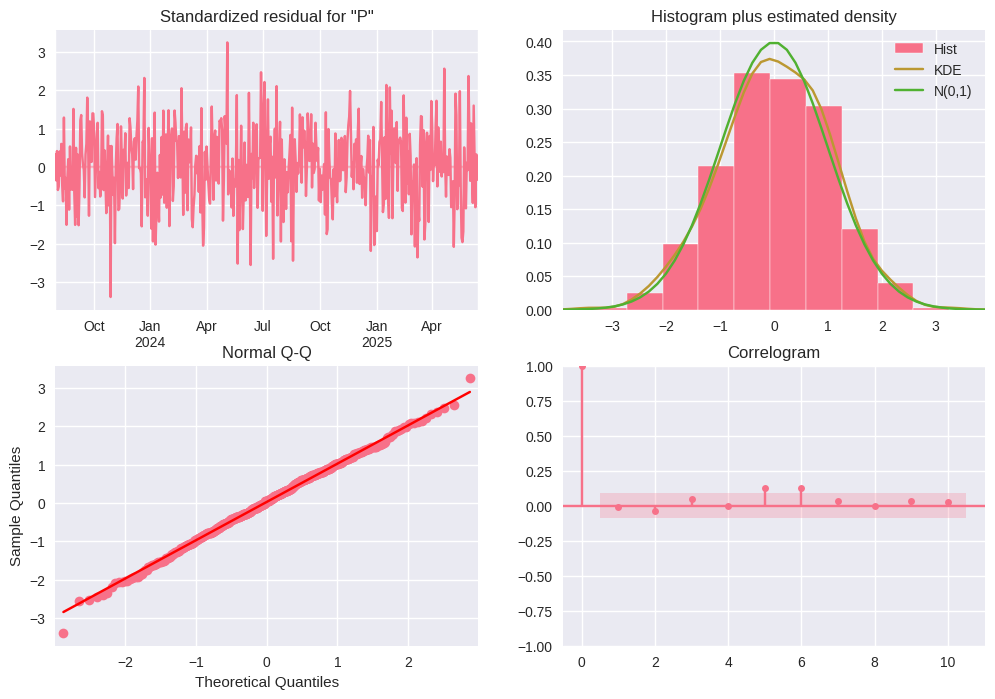

In [20]:
results.plot_diagnostics(figsize=(12, 8))
plt.show()


# **Prediksi 14 Hari ke Depan**

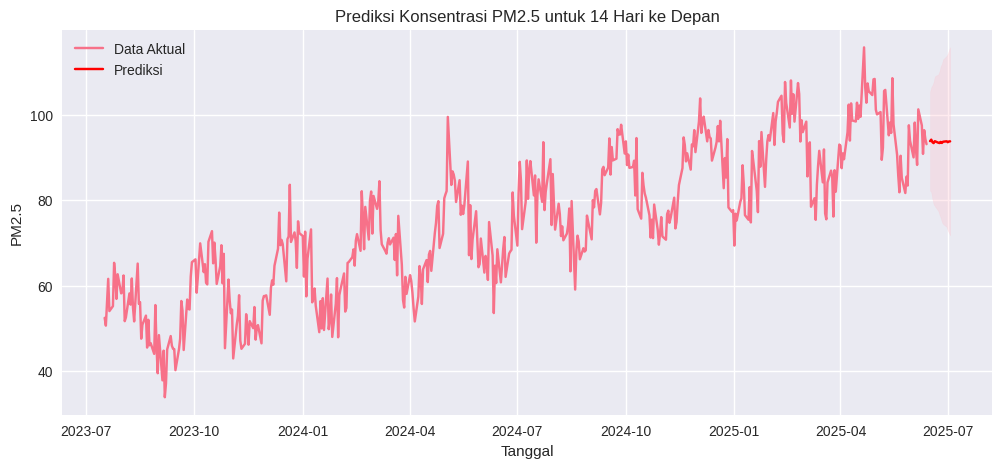

In [21]:
# Prediksi 14 hari ke depan
forecast = results.get_forecast(steps=14)
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Visualisasi hasil prediksi
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['PM2.5'], label='Data Aktual')
plt.plot(pred_mean.index, pred_mean, label='Prediksi', color='red')
plt.fill_between(pred_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prediksi Konsentrasi PM2.5 untuk 14 Hari ke Depan")
plt.xlabel("Tanggal")
plt.ylabel("PM2.5")
plt.legend()
plt.grid(True)
plt.show()


Berdasarkan grafik, model SARIMA memprediksi bahwa konsentrasi PM2.5 dalam 14 hari ke depan akan tetap tinggi dan relatif stabil, berada di atas 90 µg/m³.
Hal ini menunjukkan bahwa kualitas udara tidak menunjukkan perbaikan, bahkan cenderung tetap buruk atau berisiko terutama untuk kelompok rentan (anak-anak, lansia, penderita penyakit pernapasan).

In [22]:
# Tampilkan nilai prediksi 14 hari
print("Prediksi 14 hari ke depan:")
print(pred_mean)


Prediksi 14 hari ke depan:
2025-06-16    93.804966
2025-06-17    94.143167
2025-06-18    93.557134
2025-06-19    93.335958
2025-06-20    93.785335
2025-06-23    93.433215
2025-06-24    93.360363
2025-06-25    93.616487
2025-06-26    93.375618
2025-06-27    93.661242
2025-06-30    93.763042
2025-07-01    93.553137
2025-07-02    93.717760
2025-07-03    93.751830
Freq: B, Name: predicted_mean, dtype: float64


**Berdasarkan hasil peramalan SARIMA terhadap data PM2.5, diperkirakan bahwa dalam 14 hari ke depan, konsentrasi PM2.5 rata-rata meningkat dibandingkan 14 hari terakhir. Peningkatan ini menunjukkan bahwa kualitas udara cenderung memburuk dan berpotensi masuk ke kategori sedang hingga tidak sehat bagi kelompok sensitif. Pemantauan dan mitigasi terhadap polusi udara perlu ditingkatkan.**